# Segmentación con KMeans

### Autor: Perez Lopez Juan Carlos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

In [2]:
data = pd.read_csv('/content/marketing_campaign_with_predictions.csv')
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Predicted_Response_RF
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,1,57283200000000000,68,1617,0,0,1,0,1
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,9763200000000000,71,27,0,2,3,1,0
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,26956800000000000,60,776,1,0,2,0,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,12009600000000000,41,53,1,1,3,1,0
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,13910400000000000,44,422,1,1,3,1,0


Se eliminará la columna Predicted_Response_RF del dataframe momentaneamente, ya que corresponde a una variable objetivo o resultado previo de un modelo y no debe incluirse en el análisis de PCA ni en la agrupación de clustering, los cuales deben realizarse únicamente sobre las variables explicativas.

In [3]:
data_sin_prediccion = data.drop(columns=['Predicted_Response_RF'])
data_sin_prediccion.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,57283200000000000,68,1617,0,0,1,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,9763200000000000,71,27,0,2,3,1
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,26956800000000000,60,776,1,0,2,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,12009600000000000,41,53,1,1,3,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,13910400000000000,44,422,1,1,3,1


## Reducción de la dimensionalidad (PCA)

En este problema, hay muchos factores en los que se basará la clasificación final. Estos factores son básicamente atributos o características.

Cuanto mayor sea el número de características, más difícil será trabajar con ellas. Muchas de estas características están correlacionadas y, por lo tanto, son redundantes.

Por eso voy a realizar una reducción de la dimensionalidad de las características seleccionadas antes de someterlas a un clasificador.

La reducción de la dimensionalidad es el proceso de reducir el número de variables aleatorias que se tienen en cuenta, obteniendo un conjunto de variables principales.

El análisis de componentes principales (PCA) es una técnica para reducir la dimensionalidad de dichos conjuntos de datos, aumentando la interpretabilidad pero minimizando al mismo tiempo la pérdida de información.

**Escalado de las características utilizando el escalador estándar.**

In [4]:
# Crear una copia de los datos
ds = data_sin_prediccion.copy()
# Crear un subconjunto del data_sin_prediccion eliminando las características relacionadas con las ofertas aceptadas y las promociones.
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("Ahora todas las funciones están escaladas.")

Ahora todas las funciones están escaladas.


In [5]:
print("Dataframe que se utilizará:")
scaled_ds.head()

Dataframe que se utilizará:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


**Reduciendo a 2 dimensiones**

In [7]:
pca = PCA(n_components=2)
pca.fit(scaled_ds)
#PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,5.781993e-17,2.878602,-5.978124,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,6.424437e-17,1.709469,-4.194757,-1.323929,-0.173721,1.234851,6.168189


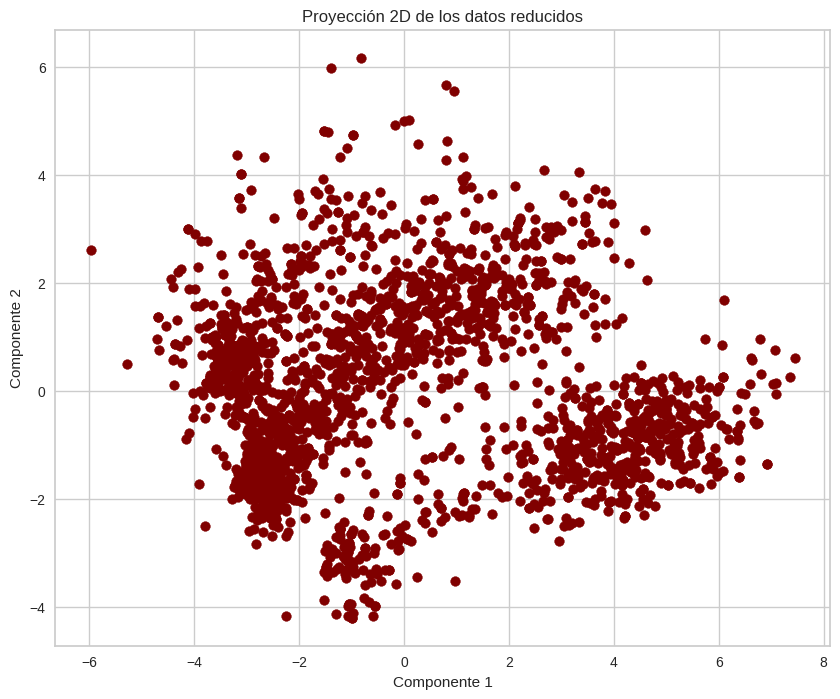

In [9]:
# Una proyección 2D de datos en una dimensión reducida
x =PCA_ds["col1"]
y =PCA_ds["col2"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)  # sin projection

ax.scatter(x, y, c="maroon", marker="o")
ax.set_title("Proyección 2D de los datos reducidos")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")

plt.show()

# CLUSTERING

Ahora que he reducido los atributos a dos dimensiones, voy a realizar la agrupación mediante el método de agrupación aglomerativa.

La agrupación aglomerativa es un método de agrupación jerárquico. Consiste en fusionar ejemplos hasta alcanzar el número deseado de agrupaciones.

Pasos del agrupamiento:

* Método del codo para determinar el número de clústeres que se van a formar
* Agrupamiento mediante agrupamiento aglomerativo

Método del codo para determinar el número de clústeres que se formarán:


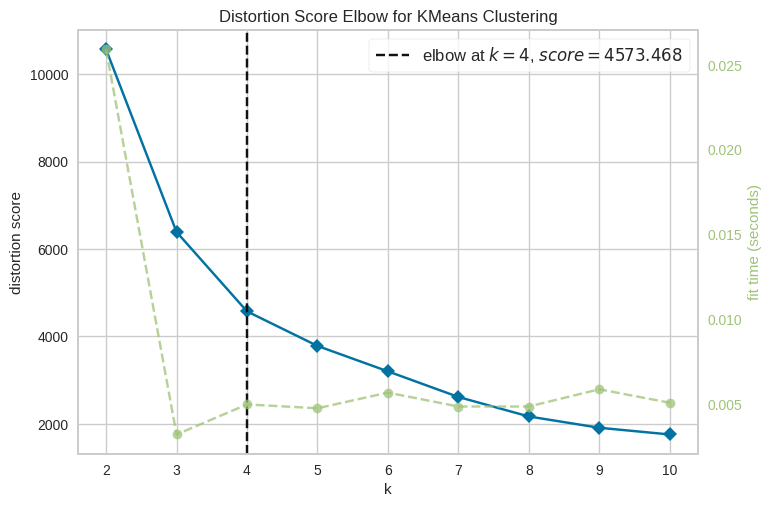

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Examen rápido del método del codo para encontrar el número de grupos que se deben crear.
print('Método del codo para determinar el número de clústeres que se formarán:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

 Se puede notar de la gráfica que cuatro clúster será el número óptimo de clústeres para estos datos.

**Ajustamos el modelo de agrupamiento aglomerativo para obtener los clústeres finales.**

In [11]:
# Iniciar el modelo de agrupamiento aglomerativo
AC = AgglomerativeClustering(n_clusters=4)
# ajustar el modelo y predecir los clústeres
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

#Añadir la función Clusters al dataframe original.
data["Clusters"]= yhat_AC

In [12]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Predicted_Response_RF,Clusters
0,0,58138.0,0,0,58,635,88,546,172,88,...,1,57283200000000000,68,1617,0,0,1,0,1,2
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,9763200000000000,71,27,0,2,3,1,0,3
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,26956800000000000,60,776,1,0,2,0,0,2
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,12009600000000000,41,53,1,1,3,1,0,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,13910400000000000,44,422,1,1,3,1,0,0


Para examinar los clústeres formados, veremos la distribución bidimensional de los clusters.

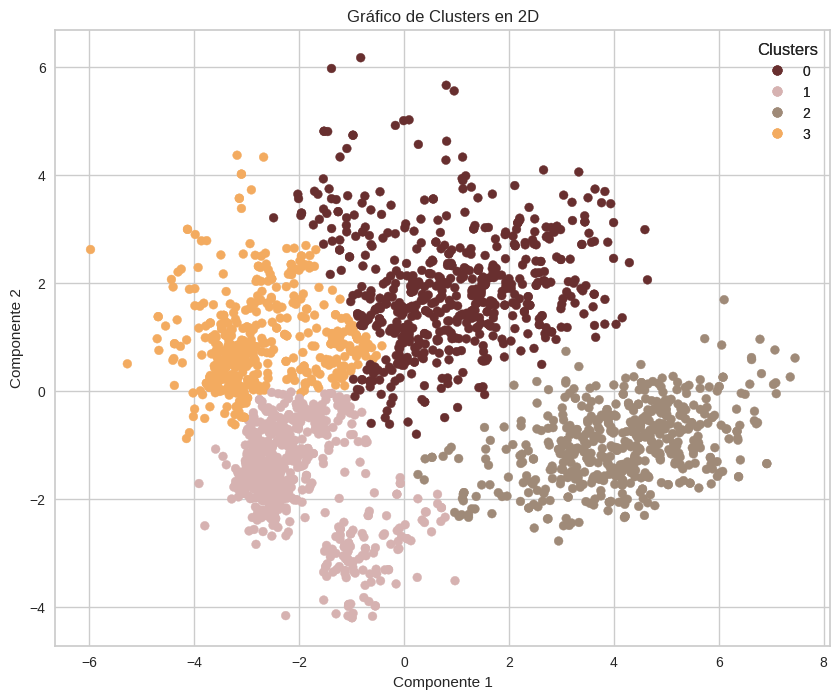

In [13]:
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Crear figura
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)  # sin 'projection'

# Graficar los puntos, coloreados por cluster
scatter = ax.scatter(x, y, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)

# Títulos y etiquetas
ax.set_title("Gráfico de Clusters en 2D")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")

# Leyenda
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Mostrar gráfico
plt.show()

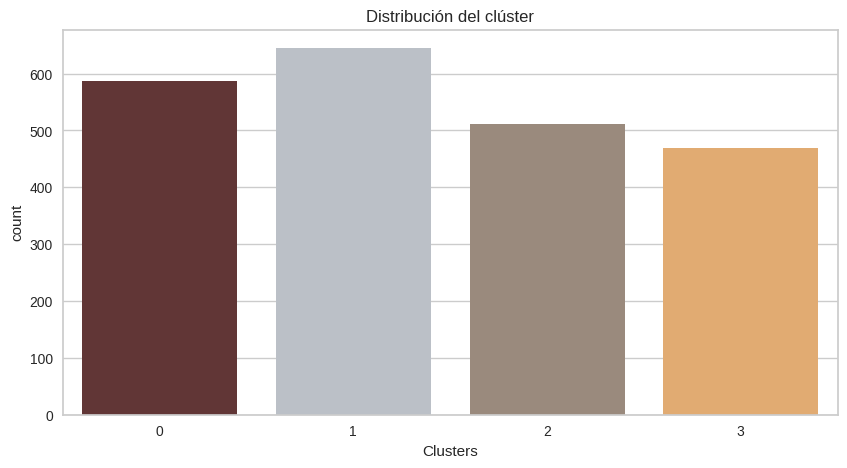

In [18]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
# cantidad de cada clústers
fig = plt.figure(figsize=(10,5))
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribución del clúster")
plt.show()

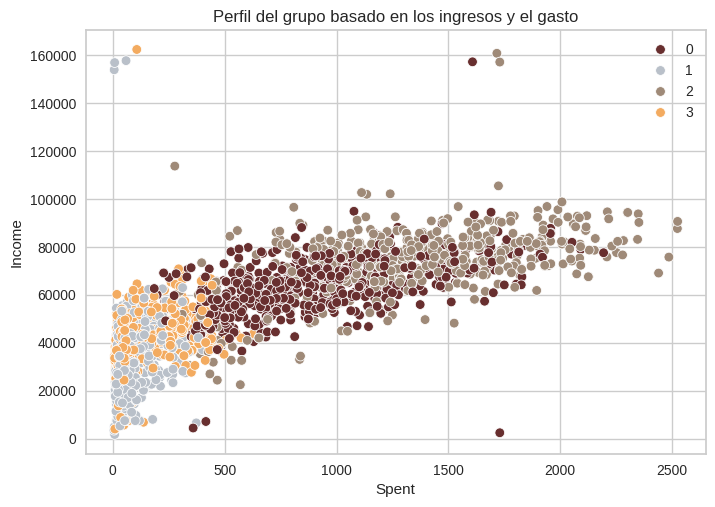

In [20]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Perfil del grupo basado en los ingresos y el gasto")
plt.legend()
plt.show()

**Interpreta las características de cada clúster**

**El gráfico de Clusters en 2D, Distribución del clúster:**

* Se puede notar 4 grupos distintos.
* el grupo mayoritario es el grupo 1
* Hay cierta superposición entre los clústeres, lo que es común en datos reales y proyecciones 2D.


**El gráfico de ingresos frente a gastos muestra el patrón de los grupos:**

* grupo 0: gastos elevados e ingresos medios
* grupo 1: gastos bajos e ingresos bajos
* grupo 2: gastos elevados e ingresos elevados
* grupo 3: gastos elevados e ingresos bajos


In [21]:
# Descarga el dataframe 'data' como un archivo CSV
data.to_csv('clientes_resultado', index=False)